# Суммаризация текста на русском языке

В этом ноутбуке мы обучим модель автоматической суммаризации текста. Суммаризация — это задача сжатия текста с сохранением ключевой информации.

## Типы суммаризации

**Экстрактивная суммаризация** — выбор наиболее важных предложений из исходного текста без изменений.

**Абстрактивная суммаризация** — генерация нового текста, который передаёт смысл исходного документа. Модель может перефразировать и комбинировать информацию.

В этом ноутбуке мы реализуем **абстрактивную суммаризацию** с помощью модели mT5.


In [1]:
import torch
import pytorch_lightning as pl
import evaluate
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import T5ForConditionalGeneration, T5Tokenizer
from tqdm import tqdm

## 2. Загрузка и анализ датасета

Используем датасет **Gazeta** — коллекция новостных статей с сайта Газета.ру. Каждый пример содержит:
- `text` — полный текст статьи
- `summary` — краткое изложение (аннотация)
- `title` — заголовок статьи

Датасет содержит около 60,000 примеров. Для ускорения обучения возьмём подвыборку.


In [2]:
dataset = load_dataset(
    "parquet",
    data_files={
        "train": "hf://datasets/IlyaGusev/gazeta/default/train/*.parquet",
        "validation": "hf://datasets/IlyaGusev/gazeta/default/validation/*.parquet",
        "test": "hf://datasets/IlyaGusev/gazeta/default/test/*.parquet"
    }
)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'title', 'date', 'url'],
        num_rows: 60964
    })
    validation: Dataset({
        features: ['text', 'summary', 'title', 'date', 'url'],
        num_rows: 6369
    })
    test: Dataset({
        features: ['text', 'summary', 'title', 'date', 'url'],
        num_rows: 6793
    })
})


In [3]:
example = dataset["train"][0]
print("Заголовок:", example["title"])
print("\nТекст статьи:", example["text"][:500], "...")
print("\nСуммаризация:", example["summary"])

Заголовок: Налог в бак

Текст статьи: Сегодня транспортный налог начисляется в зависимости от мощности автомобиля, причем цена для «сильных» машин выше, чем для малолитражек. Также ставку налога могут корректировать региональные власти: согласно Налоговому кодексу, базовый тариф, установленный правительством, может быть уменьшен в пять раз или увеличен до 10 раз. Сборы идут в региональные бюджеты, откуда растекаются на общие нужды. Транспортный налог — один из основных источников бюджетных доходов — предлагается направить исключител ...

Суммаризация: С 2011 года правительство отменяет самый раздражающий граждан налог – транспортный. Но поборы автомобилистов не прекратятся – налоги завуалируют в бензиновые акцизы и платные дороги, а цены на товары подскочат. Зато теперь собираемые деньги обещают пустить только на строительство и содержание дорог.


### Анализ распределения длин текстов

Посмотрим на распределение длин текстов и суммаризаций в символах. Это поможет выбрать оптимальные параметры для токенизации.


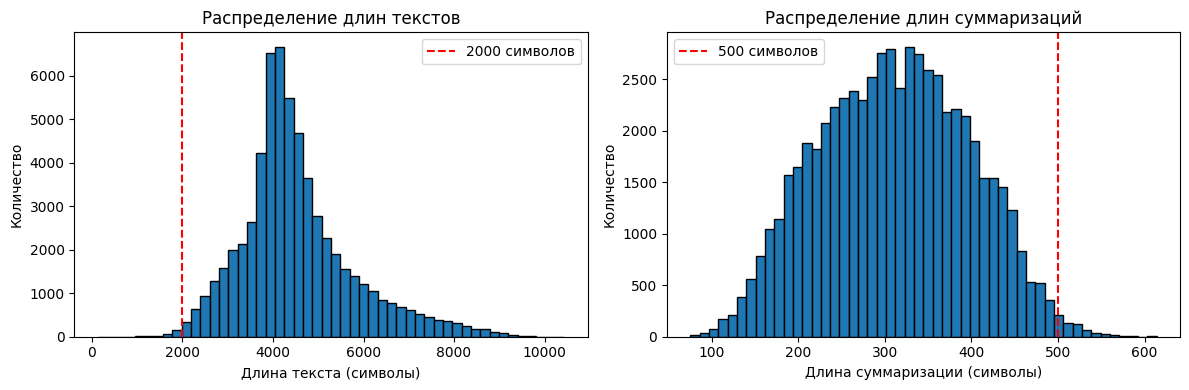

Средняя длина текста: 4525 символов
Средняя длина суммаризации: 311 символов


In [4]:
text_lengths = [len(x["text"]) for x in dataset["train"]]
summary_lengths = [len(x["summary"]) for x in dataset["train"]]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(text_lengths, bins=50, edgecolor="black")
axes[0].set_xlabel("Длина текста (символы)")
axes[0].set_ylabel("Количество")
axes[0].set_title("Распределение длин текстов")
axes[0].axvline(x=2000, color="red", linestyle="--", label="2000 символов")
axes[0].legend()

axes[1].hist(summary_lengths, bins=50, edgecolor="black")
axes[1].set_xlabel("Длина суммаризации (символы)")
axes[1].set_ylabel("Количество")
axes[1].set_title("Распределение длин суммаризаций")
axes[1].axvline(x=500, color="red", linestyle="--", label="500 символов")
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Средняя длина текста: {sum(text_lengths) / len(text_lengths):.0f} символов")
print(f"Средняя длина суммаризации: {sum(summary_lengths) / len(summary_lengths):.0f} символов")


## 3. Препроцессинг данных

### Модель mT5

Используем **mT5-small** — версию T5, предобученную на мультиязычном корпусе (включая русский). T5 (Text-to-Text Transfer Transformer) — это encoder-decoder модель, которая формулирует все NLP задачи как преобразование текста в текст.

Для суммаризации:
- **Вход (encoder)**: исходный текст статьи
- **Выход (decoder)**: сгенерированная суммаризация

### Токенизация

Ограничим длину входных текстов до 512 токенов, а выходных — до 128 токенов. Это компромисс между качеством и скоростью обучения.


In [5]:
MODEL_NAME = "google/mt5-small"
MAX_INPUT_LENGTH = 512
MAX_TARGET_LENGTH = 128

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [6]:
def preprocess_function(examples):
    inputs = ["summarize: " + text for text in examples["text"]]
    model_inputs = tokenizer(
        inputs,
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )
    
    labels = tokenizer(
        examples["summary"],
        max_length=MAX_TARGET_LENGTH,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )
    
    labels_ids = labels["input_ids"]
    labels_ids[labels_ids == tokenizer.pad_token_id] = -100
    
    model_inputs["labels"] = labels_ids
    return model_inputs


### Замена padding токенов на -100

В labels мы заменяем pad токены на `-100`. Это специальное значение, которое функция потерь `CrossEntropyLoss` игнорирует при вычислении:

$$
\mathcal{L} = -\frac{1}{N_{valid}} \sum_{i: y_i \neq -100} \log p(y_i | x)
$$

где $N_{valid}$ — количество токенов, не равных -100.

### Подготовка данных

Для ускорения обучения возьмём подвыборку из датасета.


In [7]:
TRAIN_SIZE = 5000
VAL_SIZE = 500

train_dataset = dataset["train"].shuffle(seed=42).select(range(TRAIN_SIZE))
val_dataset = dataset["validation"].shuffle(seed=42).select(range(VAL_SIZE))

print(f"Размер обучающей выборки: {len(train_dataset)}")
print(f"Размер валидационной выборки: {len(val_dataset)}")


Размер обучающей выборки: 5000
Размер валидационной выборки: 500


In [8]:
class SummarizationDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, tokenizer, max_input_length, max_target_length):
        self.dataset = hf_dataset
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        
        input_text = "summarize: " + item["text"]
        input_encoding = self.tokenizer(
            input_text,
            max_length=self.max_input_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        
        target_encoding = self.tokenizer(
            item["summary"],
            max_length=self.max_target_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        
        labels = target_encoding["input_ids"].squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100
        
        return {
            "input_ids": input_encoding["input_ids"].squeeze(),
            "attention_mask": input_encoding["attention_mask"].squeeze(),
            "labels": labels
        }


In [9]:
train_torch_dataset = SummarizationDataset(train_dataset, tokenizer, MAX_INPUT_LENGTH, MAX_TARGET_LENGTH)
val_torch_dataset = SummarizationDataset(val_dataset, tokenizer, MAX_INPUT_LENGTH, MAX_TARGET_LENGTH)

sample = train_torch_dataset[0]
print("Input shape:", sample["input_ids"].shape)
print("Labels shape:", sample["labels"].shape)


Input shape: torch.Size([512])
Labels shape: torch.Size([128])


## 4. Архитектура модели и обучение

### T5 (Text-to-Text Transfer Transformer)

T5 — это encoder-decoder модель, которая формулирует все NLP задачи как преобразование текста в текст. Архитектура основана на оригинальном Transformer с несколькими модификациями:

1. **Относительные позиционные эмбеддинги** вместо абсолютных
2. **Pre-norm** — LayerNorm применяется до attention и FFN, а не после
3. **Упрощённый FFN** без bias в линейных слоях

### Функция потерь

Для обучения используется стандартная кросс-энтропия между предсказанными токенами и целевыми:

$$
\mathcal{L} = -\sum_{t=1}^{T} \log p_\theta(y_t | y_{<t}, x)
$$

где:
- $x$ — входной текст (статья)
- $y = (y_1, \ldots, y_T)$ — целевая последовательность (суммаризация)
- $\theta$ — параметры модели

### PyTorch Lightning модуль

Используем PyTorch Lightning для удобной организации кода обучения.


In [10]:
class SummarizationModule(pl.LightningModule):
    def __init__(self, model_name, learning_rate=3e-5, warmup_steps=100):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = T5ForConditionalGeneration.from_pretrained(model_name, use_safetensors=True)
        self.learning_rate = learning_rate
        self.warmup_steps = warmup_steps
    
    def forward(self, input_ids, attention_mask, labels=None):
        return self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
    
    def training_step(self, batch, batch_idx):
        outputs = self(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"]
        )
        loss = outputs.loss
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        outputs = self(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"]
        )
        loss = outputs.loss
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        
        scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer,
            start_factor=0.1,
            end_factor=1.0,
            total_iters=self.warmup_steps
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1
            }
        }


## 5. Обучение модели

Создаём DataLoader'ы и запускаем обучение. Используем небольшой batch size из-за ограниченной памяти GPU.

### Гиперпараметры

- **Batch size**: 8 (с gradient accumulation эквивалентно 32)
- **Learning rate**: 3e-5 (стандартное значение для fine-tuning трансформеров)
- **Epochs**: 3 (достаточно для fine-tuning предобученной модели)


In [11]:
BATCH_SIZE = 8
ACCUMULATE_GRAD_BATCHES = 4
NUM_EPOCHS = 10
LEARNING_RATE = 3e-5

train_loader = DataLoader(
    train_torch_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_torch_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

print(f"Количество батчей в train: {len(train_loader)}")
print(f"Количество батчей в val: {len(val_loader)}")


Количество батчей в train: 625
Количество батчей в val: 63


In [12]:
model = SummarizationModule(
    model_name=MODEL_NAME,
    learning_rate=LEARNING_RATE,
    warmup_steps=len(train_loader) // ACCUMULATE_GRAD_BATCHES
)

trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    accelerator="auto",
    devices=1,
    accumulate_grad_batches=ACCUMULATE_GRAD_BATCHES,
    gradient_clip_val=1.0,
    log_every_n_steps=50,
    enable_progress_bar=True
)

print("Запуск обучения...")
trainer.fit(model, train_loader, val_loader)
print("Обучение завершено!")


You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Запуск обучения...



  | Name  | Type                       | Params | Mode
------------------------------------------------------------
0 | model | T5ForConditionalGeneration | 300 M  | eval
------------------------------------------------------------
300 M     Trainable params
0         Non-trainable params
300 M     Total params
1,200.707 Total estimated model params size (MB)
0         Modules in train mode
381       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Обучение завершено!


## 6. Оценка качества

### Метрики ROUGE

**ROUGE** (Recall-Oriented Understudy for Gisting Evaluation) — семейство метрик для оценки качества суммаризации.

**ROUGE-N** измеряет совпадение n-грамм между сгенерированным и эталонным текстом:

$$
\text{ROUGE-N} = \frac{\sum_{s \in \text{ref}} \sum_{\text{gram}_n \in s} \text{Count}_{\text{match}}(\text{gram}_n)}{\sum_{s \in \text{ref}} \sum_{\text{gram}_n \in s} \text{Count}(\text{gram}_n)}
$$

- **ROUGE-1**: совпадение униграмм (отдельных слов)
- **ROUGE-2**: совпадение биграмм (пар слов)

**ROUGE-L** использует наибольшую общую подпоследовательность (LCS):

$$
\text{ROUGE-L} = \frac{(1 + \beta^2) \cdot R_{lcs} \cdot P_{lcs}}{R_{lcs} + \beta^2 \cdot P_{lcs}}
$$

где $R_{lcs} = \frac{LCS(X, Y)}{m}$, $P_{lcs} = \frac{LCS(X, Y)}{n}$, $m$ и $n$ — длины эталонного и сгенерированного текстов.


In [13]:
rouge_metric = evaluate.load("rouge")

def generate_summaries(model, dataloader, tokenizer, max_length=128, num_beams=1):
    model.eval()
    device = next(model.parameters()).device
    
    predictions = []
    references = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Генерация"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"]
            
            generated_ids = model.model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=max_length,
                num_beams=num_beams,
                do_sample=False
            )
            
            decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            
            labels_clean = labels.clone()
            labels_clean[labels_clean == -100] = tokenizer.pad_token_id
            decoded_labels = tokenizer.batch_decode(labels_clean, skip_special_tokens=True)
            
            predictions.extend(decoded_preds)
            references.extend(decoded_labels)
    
    return predictions, references

In [14]:
print("Генерация суммаризаций на валидационной выборке (первые 100 примеров)...")

eval_loader = DataLoader(
    torch.utils.data.Subset(val_torch_dataset, range(min(100, len(val_torch_dataset)))),
    batch_size=8,
    shuffle=False
)

predictions, references = generate_summaries(model, eval_loader, tokenizer, num_beams=1)

results = rouge_metric.compute(predictions=predictions, references=references)

print("\nРезультаты ROUGE:")
print(f"ROUGE-1: {results['rouge1']:.4f}")
print(f"ROUGE-2: {results['rouge2']:.4f}")
print(f"ROUGE-L: {results['rougeL']:.4f}")
print(f"ROUGE-Lsum: {results['rougeLsum']:.4f}")

Генерация суммаризаций на валидационной выборке (первые 100 примеров)...


Генерация: 100%|██████████| 13/13 [05:18<00:00, 24.46s/it]


Результаты ROUGE:
ROUGE-1: 0.1306
ROUGE-2: 0.0283
ROUGE-L: 0.1243
ROUGE-Lsum: 0.1267


## 7. Инференс и демонстрация

Протестируем модель на нескольких примерах из валидационной выборки и сравним сгенерированные суммаризации с эталонными.


In [15]:
def summarize_text(model, tokenizer, text, max_input_length=512, max_output_length=128, num_beams=4):
    model.eval()
    device = next(model.parameters()).device
    
    input_text = "summarize: " + text
    inputs = tokenizer(
        input_text,
        max_length=max_input_length,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )
    
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    
    with torch.no_grad():
        generated_ids = model.model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_output_length,
            num_beams=num_beams,
            early_stopping=True
        )
    
    summary = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return summary


## 8. Визуализация Attention

Посмотрим, на какие токены входного текста модель обращает внимание при генерации каждого токена суммаризации.

**Cross-attention** в decoder показывает связь между генерируемыми токенами (query) и токенами входного текста (key/value).

In [ ]:
def get_attention_weights(model, tokenizer, text, max_input_length=512, max_output_length=50):
    model.eval()
    device = next(model.parameters()).device
    
    input_text = "summarize: " + text
    inputs = tokenizer(
        input_text,
        max_length=max_input_length,
        truncation=True,
        return_tensors="pt"
    )
    
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    
    with torch.no_grad():
        outputs = model.model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_output_length,
            num_beams=1,
            do_sample=False,
            output_attentions=True,
            return_dict_in_generate=True
        )
    
    generated_ids = outputs.sequences[0]
    generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
    
    input_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    output_tokens = tokenizer.convert_ids_to_tokens(generated_ids)
    
    cross_attentions = outputs.cross_attentions
    
    num_layers = len(cross_attentions[0])
    num_heads = cross_attentions[0][0].shape[1]
    
    all_attention = []
    for step_attention in cross_attentions:
        last_layer_attention = step_attention[-1]
        avg_heads = last_layer_attention.mean(dim=1).squeeze(0).squeeze(0)
        all_attention.append(avg_heads.cpu())
    
    attention_matrix = torch.stack(all_attention, dim=0)
    
    return {
        "input_tokens": input_tokens,
        "output_tokens": output_tokens,
        "attention_matrix": attention_matrix,
        "generated_text": generated_text,
        "input_text": text
    }

In [ ]:
def visualize_attention(attention_data, figsize=(14, 8)):
    import numpy as np
    
    attention_matrix = attention_data["attention_matrix"].numpy()
    input_tokens = attention_data["input_tokens"]
    output_tokens = attention_data["output_tokens"]
    
    input_len = min(len(input_tokens), attention_matrix.shape[1])
    output_len = min(len(output_tokens), attention_matrix.shape[0])
    
    attention_matrix = attention_matrix[:output_len, :input_len]
    input_tokens = input_tokens[:input_len]
    output_tokens = output_tokens[:output_len]
    
    input_tokens = [t.replace("▁", "_") for t in input_tokens]
    output_tokens = [t.replace("▁", "_") for t in output_tokens]
    
    fig, ax = plt.subplots(figsize=figsize)
    
    im = ax.imshow(attention_matrix, cmap="Blues", aspect="auto")
    
    ax.set_xticks(range(len(input_tokens)))
    ax.set_yticks(range(len(output_tokens)))
    ax.set_xticklabels(input_tokens, rotation=90, fontsize=8)
    ax.set_yticklabels(output_tokens, fontsize=8)
    
    ax.set_xlabel("Входные токены")
    ax.set_ylabel("Выходные токены")
    ax.set_title("Cross-Attention: на что смотрит модель при генерации")
    
    plt.colorbar(im, ax=ax, label="Вес внимания")
    plt.tight_layout()
    plt.show()
    
    print(f"\nВходной текст: {attention_data['input_text'][:200]}...")
    print(f"\nСгенерированная суммаризация: {attention_data['generated_text']}")

In [ ]:
example = val_dataset[0]
attention_data = get_attention_weights(model, tokenizer, example["text"][:500])
visualize_attention(attention_data)

In [16]:
print("Примеры суммаризации:\n")
print("=" * 80)

for i in range(5):
    example = val_dataset[i]
    original_text = example["text"][:1000]
    reference_summary = example["summary"]
    
    generated_summary = summarize_text(model, tokenizer, example["text"])
    
    print(f"\nПример {i + 1}")
    print("-" * 40)
    print(f"Текст: {original_text}...")
    print(f"\nЭталонная суммаризация:\n{reference_summary}")
    print(f"\nСгенерированная суммаризация:\n{generated_summary}")
    print("=" * 80)


Примеры суммаризации:


Пример 1
----------------------------------------
Текст: Писатель Григорий Чхартишвили , более известный как Борис Акунин , сообщил о заражении коронавирусом. Об этом он написал у себя в Facebook. «Я забросил Facebook, потому что валяюсь с модной болезнью, — заявил он. — Малость окрепну — обязательно поделюсь впечатлениями». Автор серии «Приключения Эраста Фандорина» также выразил мнение, что страх перед COVID-19 «гораздо страшнее самого коронавируса», однако осторожность во время пандемии соблюдать нужно. «Спойлер: страх перед коронавирусом гораздо страшнее самого коронавируса. Осторожным быть нужно, а паниковать незачем», — заключил писатель. Борис Акунин родился на территории Грузинской ССР — в городе Зестафони — 20 мая 1956 года. В настоящее время 63-летний писатель, согласно СМИ, проживает в Лондоне. На его счету такие произведения, как «Писатель и самоубийство», популярная серия «Приключения Эраста Фандорина», в которую вошли, в частности, «Азазель», «Туре